# Cross Validation

It is a method thatgoes beyond evaluating a single model using a single Train/Test split of the data by using multiple Train/Test splits, each of which is used to train and evaluate a separate model.

## Why is this better?

- The accuracy score we get from running a classifier can vary quite a bit just by chance depending on the specific samples that happen to end up in the training set.
- Cross validation gives a more stable and reliable estimates of how classifiers are likely to perform on average by running multiple training test splits and then averaging the results, instead of relying entirely on a single particular training set.

<img src="resources/cv_1.png" width = "600">

- Each of these parts are called **fold**
- One benefit of computing the accuracy of a model on multiple splits instead of a single split, is that it gives us potentially useful information about how sensitive the model is to the nature of the specific training set.
- We can do sort of worst/best case performance estimate from these multiple scores.

## Stratified Cross-validation
Stratified folds each contain a proportion of classes that matches the overall dataset. Now, all classes will be fairly represented in the test set.

- For regression sklearn uses regular k-fold cross-validation since the concept of preserving class proportions isn't relevant for this case.

## Leave-one-out cross validation
It is a k-fold cross validation with k set to the number of data samples in the data set.

<img src="resources/cv_2.png" width = "600">

- Test set consists of a single observation
- Training set consists of the rest of the data
- It takes a lot of computational power, but it might make sense for small datasets to improve the model performance.

## Extra

- Sometimes we want to evaluate the effect that an important parameter of a model has on the cross-validation scores. For that we can use the **validation_curve** function.

<img src="resources/cv_3.png" width = "600">

- **Cross validation is used to evaluate a model**, not to parameter-tune it. For that we have tools such as Grid-Search.

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import warnings

warnings.filterwarnings('ignore')

In [6]:
# Datasets
from sklearn.datasets import make_regression, make_friedman1, make_classification, make_blobs
from sklearn.datasets import load_breast_cancer
from utils.adspy_shared_utilities import load_crime_dataset

X_R1, y_R1 = make_regression(n_samples = 100, n_features = 1, n_informative = 1, bias = 150.0, noise = 30, random_state = 0)
X_F1, y_F1 = make_friedman1(n_samples = 100, n_features = 7, random_state = 0)
X_C2, y_C2 = make_classification(n_samples = 100, n_features = 2, n_redundant = 0, n_informative = 2, n_clusters_per_class = 1, flip_y = .1, class_sep = .5, random_state = 0)
X_D2, y_D2 = make_blobs(n_samples = 100, n_features = 2, centers = 8, cluster_std = 1.3, random_state = 4)
y_D2 = y_D2 % 2


# Breast cancer dataset for classification
cancer = load_breast_cancer()
(X_cancer, y_cancer) = load_breast_cancer(return_X_y = True)

# Communities and Crime dataset
(X_crime, y_crime) = load_crime_dataset('data/CommViolPredUnnormalizedData.txt')

# Load data
fruits = pd.read_table('data/fruit_data_with_colors.txt')

X_fruits_2d = fruits[['height', 'width']]
y_fruits_2d = fruits['fruit_label']

target_names_fruits = ['apple', 'mandarin', 'orange', 'lemon']


## Example based on k-NN classifier with fruit dataset (2 features)

In [8]:
from sklearn.model_selection import cross_val_score

clf = KNeighborsClassifier(n_neighbors = 5)
X = X_fruits_2d
y = y_fruits_2d
cv_scores = cross_val_score(clf, X, y)

print('Cross-validation scores (3-fold):', cv_scores)
print('Mean cross-validation score (3-fold): {:.3f}'
     .format(np.mean(cv_scores)))

Cross-validation scores (3-fold): [0.75       0.75       0.83333333 0.83333333 0.81818182]
Mean cross-validation score (3-fold): 0.797


### A note on performing cross-validation for more advanced scenarios.

In some cases (e.g. when feature values have very different ranges), we've seen the need to scale or normalize the training and test sets before use with a classifier. The proper way to do cross-validation when you need to scale the data is *not* to scale the entire dataset with a single transform, since this will indirectly leak information into the training data about the whole dataset, including the test data (see the lecture on data leakage later in the course).  Instead, scaling/normalizing must be computed and applied for each cross-validation fold separately.  To do this, the easiest way in scikit-learn is to use *pipelines*.  While these are beyond the scope of this course, further information is available in the scikit-learn documentation here:

[http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html](http://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)

or the Pipeline section in the recommended textbook: Introduction to Machine Learning with Python by Andreas C. Müller and Sarah Guido (O'Reilly Media).

## Validation curve example

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

param_range = np.logspace(-3, 3, 4)
train_scores, test_scores = validation_curve(SVC(), X, y,
                                            param_name='gamma',
                                            param_range=param_range, cv=3)

In [11]:
print(f"Train scores:\n{train_scores}")
print("-" * 25)
print(f"Test scores:\n{test_scores}")

Train scores:
[[0.46153846 0.43589744 0.425     ]
 [0.84615385 0.71794872 0.75      ]
 [0.92307692 0.8974359  0.925     ]
 [1.         1.         0.975     ]]
-------------------------
Test scores:
[[0.5        0.3        0.31578947]
 [0.85       0.7        0.63157895]
 [0.55       0.85       0.68421053]
 [0.4        0.2        0.36842105]]


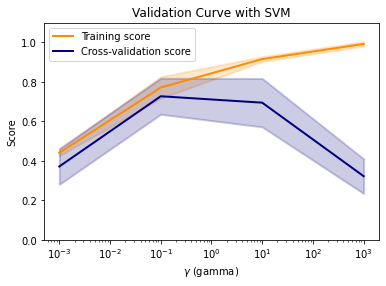

In [12]:
# This code based on scikit-learn validation_plot example
#  See:  http://scikit-learn.org/stable/auto_examples/model_selection/plot_validation_curve.html

# Scores averages and stds
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Matplotlib figure
plt.figure()

plt.title('Validation Curve with SVM')
plt.xlabel('$\gamma$ (gamma)')
plt.ylabel('Score')
plt.ylim(0.0, 1.1)
lw = 2      # linewidth


#### Train scores plot
# To plot the line (avg)
plt.semilogx(param_range, train_scores_mean, label='Training score',
            color='darkorange', lw=lw)

# To plot the range (std)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                train_scores_mean + train_scores_std, alpha=0.2,
                color='darkorange', lw=lw)

#### Test scores plot
# To plot the line (avg)
plt.semilogx(param_range, test_scores_mean, label='Cross-validation score',
            color='navy', lw=lw)

# To plot the range (std)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                test_scores_mean + test_scores_std, alpha=0.2,
                color='navy', lw=lw)

plt.legend(loc='best')
plt.show()